In [1]:
%load_ext autoreload
%autoreload 2


In [58]:
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader
from neural_regress.regress_lib import sweep_regressors
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch

import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge

#%% Utility Functions

def load_neural_data(data_path, subject_id, stimroot):
    """Load neural data and image file paths."""
    from core.data_utils import load_from_hdf5
    data = load_from_hdf5(data_path)
    # Meta data
    brain_area = data[subject_id]["neuron_metadata"]["brain_area"]
    ncsnr = data[subject_id]["neuron_metadata"]["ncsnr"]
    reliability = data[subject_id]["neuron_metadata"]["reliability"]
    # Display parameters
    stim_pos = data[subject_id]['trials']['stimulus_pos_deg']
    stim_size = data[subject_id]['trials']['stimulus_size_pix']
    # Response data
    resp_mat = data[subject_id]['repavg']['response_peak']  # Peak, avg response
    resp_temp_mat = data[subject_id]['repavg']['response_temporal']  # Temporal response
    stimulus_names = data[subject_id]['repavg']['stimulus_name']
    image_fps = [f"{stimroot}/{stimname.decode('utf8')}" for stimname in stimulus_names]
    return {
        'brain_area': brain_area,
        'ncsnr': ncsnr,
        'reliability': reliability,
        'stim_pos': stim_pos,
        'stim_size': stim_size,
        'resp_mat': resp_mat,
        'resp_temp_mat': resp_temp_mat,
        'image_fps': image_fps,
    }


@th.no_grad()
def record_features(model, fetcher, dataset, batch_size=20, device="cuda"):
    """Record features from the model using the fetcher."""
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.to(device).eval()
    feat_col = {}
    for imgs, _ in tqdm(loader):
        model(imgs.to(device))
        for key in fetcher.activations.keys():
            if key not in feat_col:
                feat_col[key] = []
            feat_col[key].append(fetcher[key].cpu())
    for key in feat_col.keys():
        feat_col[key] = th.cat(feat_col[key], dim=0)
        print(key, feat_col[key].shape)
    return feat_col


def extract_features(model, dataset, layer_name="last_block", batch_size=20, device="cuda"):
    """Extract features from a specified layer of the model."""
    fetcher = featureFetcher_module()
    fetcher.record_module(model.layer4, layer_name, ) # this is for ResNet50, specifically, modify as needed
    feat_dict = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()
    del fetcher
    return feat_dict


def LinearLayer_from_sklearn(model):
    """Convert a sklearn linear model to a PyTorch Linear layer."""
    if isinstance(model, sklearn.model_selection._search.GridSearchCV):
        model = model.best_estimator_
    assert model.coef_.shape[1] == model.n_features_in_
    readout = nn.Linear(model.coef_.shape[1], model.coef_.shape[0], bias=True)
    readout.weight.data = th.tensor(model.coef_).float()
    readout.bias.data = th.tensor(model.intercept_).float()
    return readout


def perform_regression(feat_dict, resp_mat, reliability, thresh=0.8, layerkey="last_block",):
    """Perform regression using extracted features and neural responses."""
    # TODO: add customizable feature transforms
    # TODO: add customizable regressors
    # Preprocess features
    feat_tsr = feat_dict[layerkey]
    print(feat_tsr.shape)
    featmat = feat_tsr.view(feat_tsr.shape[0], -1).numpy()
    featmat_avg = feat_tsr.mean(dim=(2, 3))  # B x C
    centpos = (feat_tsr.shape[2] // 2, feat_tsr.shape[3] // 2)
    featmat_rf = feat_tsr[:, :, centpos[0]:centpos[0]+1, centpos[1]:centpos[1]+1].mean(dim=(2,3))  # B x n_components
    # featmat_CLS = feat_tsr[:, 0, :].numpy()
    Xdict = {"sp_avg": featmat_avg, "sp_rf": featmat_rf, 'none': featmat} # "srp": srp_featmat, "pca": pca_featmat,
    # Xdict = {"sp_avg": featmat_avg, "cls": featmat_CLS}
    # Define regressors
    ridge = Ridge(alpha=1.0)
    kr_rbf = KernelRidge(alpha=1.0, kernel="rbf", gamma=None)
    # Mask reliable channels
    chan_mask = reliability > thresh
    print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
    regressors = [ridge, kr_rbf]
    regressor_names = ["Ridge", "KernelRBF"]
    result_df, fit_models = sweep_regressors(Xdict, resp_mat[:, chan_mask], regressors, regressor_names)
    return result_df, fit_models, chan_mask, Xdict


def perform_regression_sweeplayer(feat_dict, resp_mat, layer_names=None, 
                                  dimred_list=["pca1000", "sp_cent", "sp_avg", "full",],
                                  regressor_list=["Ridge",], verbose=True,
                                  pretrained_Xtransforms={}):
    """Perform regression using extracted features and neural responses."""
    # TODO: add customizable feature transforms
    # TODO: add customizable regressors
    # Preprocess features
    Xdict = {}
    tfm_dict = {}
    for layerkey in feat_dict.keys() if layer_names is None else layer_names:
        feat_tsr = feat_dict[layerkey]
        print(layerkey, feat_tsr.shape)
        featmat = feat_tsr.flatten(start_dim=1)
        for dimred in dimred_list:
            if dimred.startswith("pca"):
                n_components = int(dimred.split("pca")[-1])
                if f"{layerkey}_{dimred}" in pretrained_Xtransforms:
                    pca_transformer = pretrained_Xtransforms[f"{layerkey}_{dimred}"]
                    featmat_pca = pca_transformer.transform(featmat)
                else:
                    pca_transformer = PCA(n_components=n_components)
                    featmat_pca = pca_transformer.fit_transform(featmat)
                Xdict.update({f"{layerkey}_{dimred}": featmat_pca})
                tfm_dict.update({f"{layerkey}_{dimred}": pca_transformer})
            elif dimred == "srp":
                srp_transformer = SparseRandomProjection()
                featmat_srp = srp_transformer.fit_transform(featmat)
                if f"{layerkey}_{dimred}" in pretrained_Xtransforms:
                    srp_transformer = pretrained_Xtransforms[f"{layerkey}_{dimred}"]
                    featmat_srp = srp_transformer.transform(featmat)
                else:
                    srp_transformer = SparseRandomProjection()
                    featmat_srp = srp_transformer.fit_transform(featmat)
                Xdict.update({f"{layerkey}_{dimred}": featmat_srp})
                tfm_dict.update({f"{layerkey}_{dimred}": srp_transformer})
            elif dimred.startswith("srp"):
                n_components = int(dimred.split("srp")[-1])
                if f"{layerkey}_{dimred}" in pretrained_Xtransforms:
                    srp_transformer = pretrained_Xtransforms[f"{layerkey}_{dimred}"]
                    featmat_srp = srp_transformer.transform(featmat)
                else:
                    srp_transformer = SparseRandomProjection(n_components=n_components)
                    featmat_srp = srp_transformer.fit_transform(featmat)
                Xdict.update({f"{layerkey}_{dimred}": featmat_srp})
            elif dimred == "sp_avg":
                featmat_avg = feat_tsr.mean(dim=(2, 3))  # B x C
                Xdict.update({f"{layerkey}_sp_avg": featmat_avg})
                tfm_dict.update({f"{layerkey}_sp_avg": lambda x: x.mean(dim=(2,3))})
            elif dimred == "sp_cent":
                centpos = (feat_tsr.shape[2] // 2, feat_tsr.shape[3] // 2)
                featmat_cent = feat_tsr[:, :, centpos[0]:centpos[0]+1, centpos[1]:centpos[1]+1].mean(dim=(2,3))  # B x n_components
                Xdict.update({f"{layerkey}_sp_cent": featmat_cent})
                tfm_dict.update({f"{layerkey}_sp_cent": lambda x: x[:, :, centpos[0]:centpos[0]+1, centpos[1]:centpos[1]+1].mean(dim=(2,3))})
            elif dimred == "full":
                Xdict.update({f"{layerkey}_full": featmat})
                tfm_dict.update({f"{layerkey}_full": lambda x: x.flatten(start_dim=1)})
            else:
                raise ValueError(f"Unknown dimension reduction method: {dimred}")
        
    # Define regressors
    regressors = []
    for regressor_name in regressor_list:
        if regressor_name == "Ridge":
            regressors.append(Ridge(alpha=1.0))
        elif regressor_name == "KernelRBF":
            regressors.append(KernelRidge(alpha=1.0, kernel="rbf", gamma=None))
        else:
            raise ValueError(f"Unknown regressor: {regressor_name}")
    regressor_names = regressor_list
    
    result_df, fit_models = sweep_regressors(Xdict, resp_mat, regressors, regressor_names, verbose=verbose)
    return result_df, fit_models, Xdict, tfm_dict


from sklearn.linear_model import RidgeCV
def perform_regression_sweeplayer_RidgeCV(feat_dict, resp_mat, layer_names=None, 
                                  dimred_list=["pca1000", "sp_cent", "sp_avg", "full",],
                                  alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                                  alpha_per_target=True,
                                  pretrained_Xtransforms={},
                                  verbose=True):
    """Perform regression using extracted features and neural responses."""
    # TODO: add customizable feature transforms
    # TODO: add customizable regressors
    # Preprocess features
    Xdict = {}
    tfm_dict = {}
    for layerkey in feat_dict.keys() if layer_names is None else layer_names:
        feat_tsr = feat_dict[layerkey]
        print(layerkey, feat_tsr.shape)
        featmat = feat_tsr.flatten(start_dim=1)
        for dimred in dimred_list:
            if dimred.startswith("pca"):
                n_components = int(dimred.split("pca")[-1])
                if f"{layerkey}_{dimred}" in pretrained_Xtransforms:
                    pca_transformer = pretrained_Xtransforms[f"{layerkey}_{dimred}"]
                    featmat_pca = pca_transformer.transform(featmat)
                else:
                    pca_transformer = PCA(n_components=n_components)
                    featmat_pca = pca_transformer.fit_transform(featmat)
                Xdict.update({f"{layerkey}_{dimred}": featmat_pca})
                tfm_dict.update({f"{layerkey}_{dimred}": pca_transformer})
            elif dimred == "srp":
                srp_transformer = SparseRandomProjection()
                featmat_srp = srp_transformer.fit_transform(featmat)
                if f"{layerkey}_{dimred}" in pretrained_Xtransforms:
                    srp_transformer = pretrained_Xtransforms[f"{layerkey}_{dimred}"]
                    featmat_srp = srp_transformer.transform(featmat)
                else:
                    srp_transformer = SparseRandomProjection()
                    featmat_srp = srp_transformer.fit_transform(featmat)
                Xdict.update({f"{layerkey}_{dimred}": featmat_srp})
                tfm_dict.update({f"{layerkey}_{dimred}": srp_transformer})
            elif dimred.startswith("srp"):
                n_components = int(dimred.split("srp")[-1])
                if f"{layerkey}_{dimred}" in pretrained_Xtransforms:
                    srp_transformer = pretrained_Xtransforms[f"{layerkey}_{dimred}"]
                    featmat_srp = srp_transformer.transform(featmat)
                else:
                    srp_transformer = SparseRandomProjection(n_components=n_components)
                    featmat_srp = srp_transformer.fit_transform(featmat)
                Xdict.update({f"{layerkey}_{dimred}": featmat_srp})
                tfm_dict.update({f"{layerkey}_{dimred}": srp_transformer})
            elif dimred == "sp_avg":
                featmat_avg = feat_tsr.mean(dim=(2, 3))  # B x C
                Xdict.update({f"{layerkey}_sp_avg": featmat_avg})
                tfm_dict.update({f"{layerkey}_sp_avg": lambda x: x.mean(dim=(2,3))})
            elif dimred == "sp_cent":
                centpos = (feat_tsr.shape[2] // 2, feat_tsr.shape[3] // 2)
                featmat_cent = feat_tsr[:, :, centpos[0]:centpos[0]+1, centpos[1]:centpos[1]+1].mean(dim=(2,3))  # B x n_components
                Xdict.update({f"{layerkey}_sp_cent": featmat_cent})
                tfm_dict.update({f"{layerkey}_sp_cent": lambda x: x[:, :, centpos[0]:centpos[0]+1, centpos[1]:centpos[1]+1].mean(dim=(2,3))})
            elif dimred == "full":
                Xdict.update({f"{layerkey}_full": featmat})
                tfm_dict.update({f"{layerkey}_full": lambda x: x.flatten(start_dim=1)})
            else:
                raise ValueError(f"Unknown dimension reduction method: {dimred}")
        
    # Define regressors
    regressors = [RidgeCV(alphas=alpha_list, alpha_per_target=alpha_per_target)]
    regressor_names = ["RidgeCV"]
    
    result_df, fit_models = sweep_regressors(Xdict, resp_mat, regressors, regressor_names, verbose=verbose)
    return result_df, fit_models, Xdict, tfm_dict


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
    

def visualize_results(img_col, D2, ):
    """Visualize the optimized images."""
    row_num = len(img_col) // 5 + (len(img_col) % 5 > 0)
    figh, axs = plt.subplots(row_num, 5, figsize=(25, row_num * 5))
    for i, ax in enumerate(axs.flat):
        plt.sca(ax)
        if i >= len(img_col):
            ax.axis("off")
            continue
        tup = img_col[i]
        plot_maco(tup[0], tup[1])
        plt.title(f"Unit {i} R2={D2[i]:.2f}")


def load_model_transform(modelname, device="cuda"):
    # Prepare model and transforms
    if modelname == "resnet50_robust":
        model = resnet50(pretrained=False)
        model.load_state_dict(th.load("/teamspace/studios/this_studio/checkpoints/imagenet_linf_8_pure.pt"))
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50":
        model = resnet50(pretrained=True)
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50_clip":
        import clip
        model_clip, preprocess = clip.load('RN50', device=device)
        model = model_clip.visual
        transforms_pipeline = preprocess
    elif modelname == "resnet50_dino":
        # https://github.com/facebookresearch/dino
        model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        raise ValueError(f"Unknown model: {modelname}")
        # model = timm.create_model(modelname, pretrained=True).to(device).eval()
        # data_config = timm.data.resolve_model_data_config(model)
        # transforms_pipeline = timm.data.create_transform(**data_config, is_training=False)
    model = model.to(device).eval()
    model.requires_grad_(False)
    
    return model, transforms_pipeline


In [3]:
import os
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"

In [4]:
# !pip install git+https://github.com/openai/CLIP.git

In [5]:
data_path = join(dataroot, "nsd_shared1000_6monkeys_2024.h5")
stimroot = join(dataroot, "shared1000")
subject_id = 'paul_240713-240710' # 'paul_20240713-20240710' 
modelname = "resnet50_clip" # "flexivit_base.1000ep_in21k",
layer_name = "layer4"
RD_method = "pca1000" 
batch_size = 96 
figdir = join(dataroot, "model_outputs", subject_id, )
os.makedirs(figdir, exist_ok=True)
device = "cuda" 
reliability_thresh = 0.7

maco_hyperparams = dict(total_steps=1000, learning_rate=1.0, image_size=1280,
        model_input_size=224, noise=0.10, values_range=(-2.5, 2.5),
        crops_per_iteration=6, box_size=(0.20, 0.25),)

result_df_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab.csv") # join(figdir, f"sweep_regressors_highreliab_{modelname}.csv")
readout_path = join(figdir, f"{subject_id}_{modelname}_{layer_name}_{RD_method}_readout.pth")
meta_path = join(figdir, f"{subject_id}_{modelname}_{layer_name}_{RD_method}_meta.pth")
Xtransform_path = join(figdir, f"{subject_id}_{modelname}_{layer_name}_{RD_method}_Xtransform.pkl")

model, transforms_pipeline = load_model_transform(modelname, device=device)

# Load data
data_dict = load_neural_data(data_path, subject_id, stimroot)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
# Prepare dataset
dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)

The (227, 227) setting is overwritten by the size in custom transform


The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/12 [00:00<?, ?it/s]

layer4 torch.Size([1110, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > 0.7 N=8
layer4 torch.Size([1110, 2048, 7, 7])


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


                        alpha  train_score  test_score    n_feat
layer4_pca1000 Ridge  10000.0     0.942423    0.392906    1000.0
layer4_sp_cent Ridge   1000.0     0.697641    0.224712    2048.0
layer4_sp_avg  Ridge    100.0     0.663688    0.270134    2048.0
layer4_full    Ridge  10000.0     0.960805    0.428098  100352.0
[0.8608589  0.872742   0.8778979  0.86056024 0.7441919  0.8715466
 0.74101317 0.8577034 ]
FeatureFetcher hooks all freed
torch.Size([])


100%|██████████| 1000/1000 [00:15<00:00, 66.23it/s]


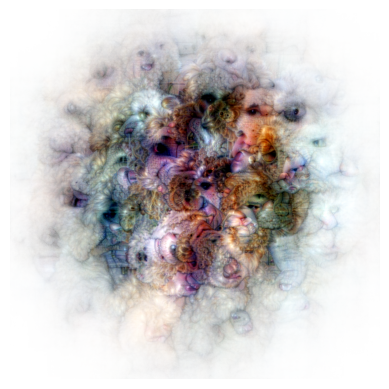

Optimizing unit 0
D^2: 0.8608589172363281


100%|██████████| 1000/1000 [00:11<00:00, 83.71it/s]


Optimizing unit 1
D^2: 0.8727419972419739


100%|██████████| 1000/1000 [00:11<00:00, 83.52it/s]


Optimizing unit 2
D^2: 0.8778979182243347


100%|██████████| 1000/1000 [00:11<00:00, 83.54it/s]


Optimizing unit 3
D^2: 0.8605602383613586


100%|██████████| 1000/1000 [00:11<00:00, 83.73it/s]


Optimizing unit 4
D^2: 0.7441918849945068


100%|██████████| 1000/1000 [00:11<00:00, 83.74it/s]


Optimizing unit 5
D^2: 0.8715466260910034


100%|██████████| 1000/1000 [00:11<00:00, 83.51it/s]


Optimizing unit 6
D^2: 0.7410131692886353


100%|██████████| 1000/1000 [00:11<00:00, 83.54it/s]


Optimizing unit 7
D^2: 0.8577033877372742


100%|██████████| 1000/1000 [00:11<00:00, 83.80it/s]


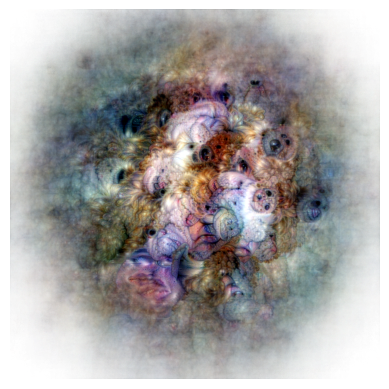

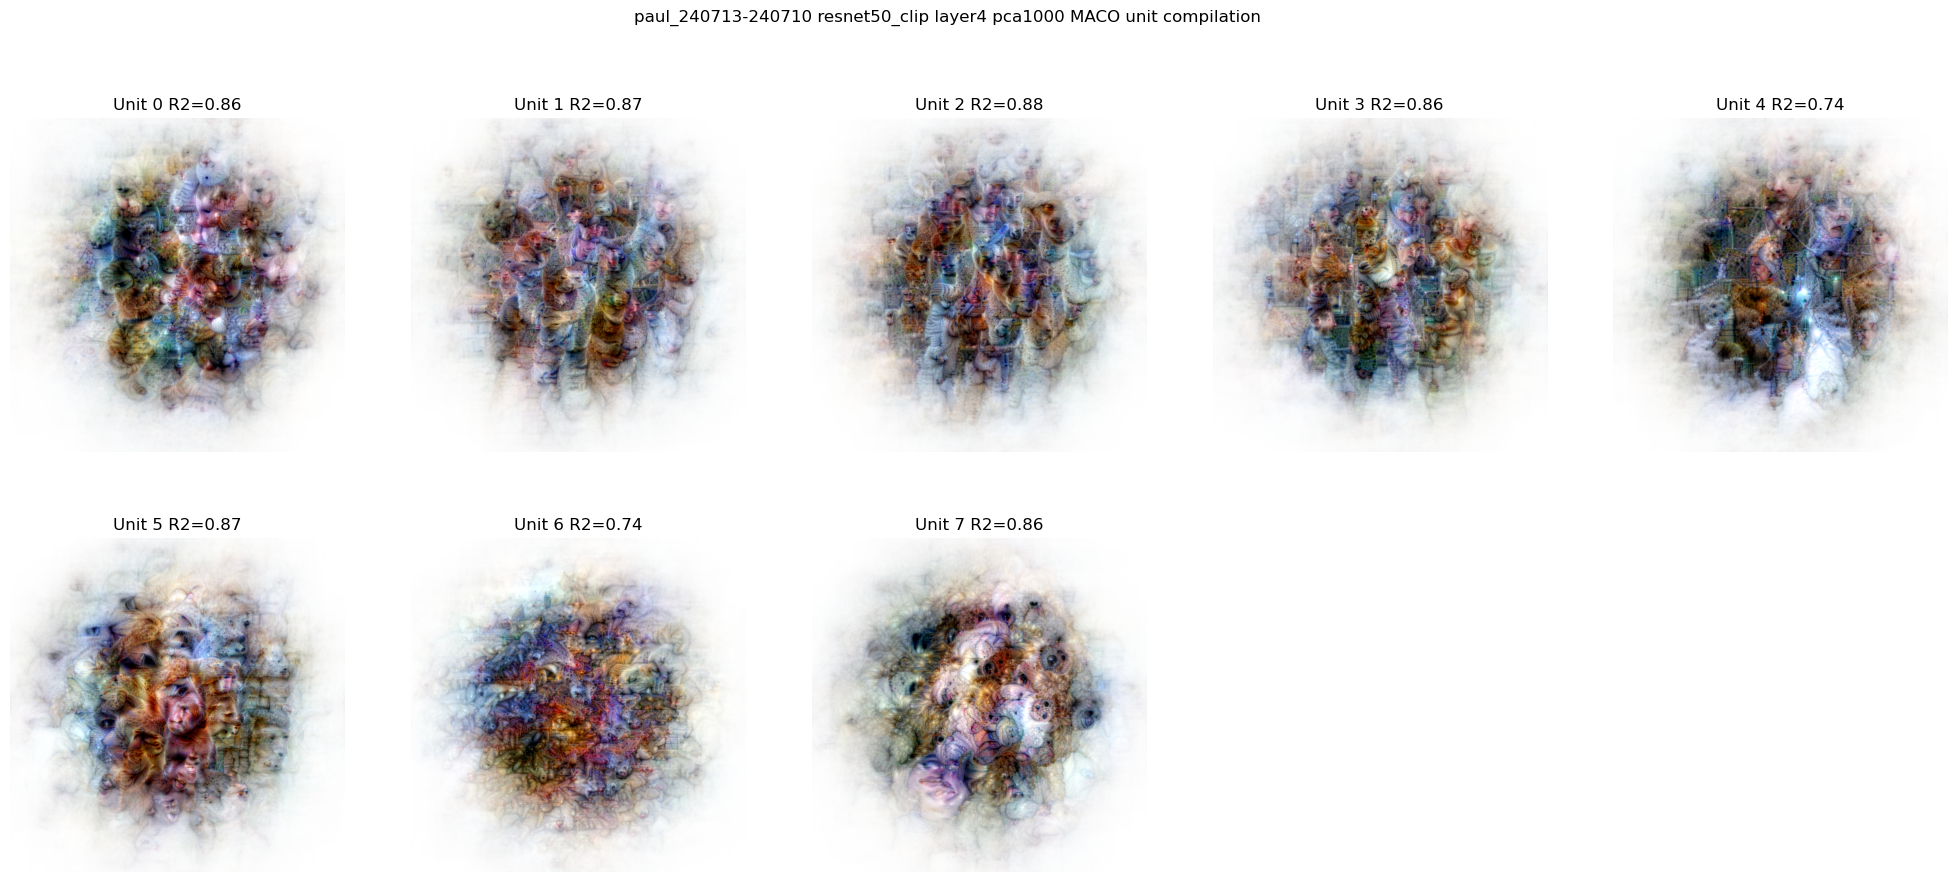

In [5]:
fetcher = featureFetcher_module()
fetcher.record_module(model.layer4, layer_name, )
feat_dict = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()

thresh = reliability_thresh
chan_mask = reliability > thresh
resp_mat_sel = resp_mat[:, chan_mask]
print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
result_df, fit_models, Xdict, Xtfmer = perform_regression_sweeplayer(feat_dict, 
            resp_mat_sel, layer_names=[layer_name,], # 'layer2', 'layer3', 
            regressor_list=["Ridge",], dimred_list=["pca1000", "sp_cent", "sp_avg", "full"])

result_df.to_csv(result_df_path)

readout = LinearLayer_from_sklearn(fit_models[(f"{layer_name}_{RD_method}", 'Ridge')])
with th.no_grad():
    pred_resp = readout(th.tensor(Xdict[f"{layer_name}_{RD_method}"]).float())
D2 = 1 - ((resp_mat_sel - pred_resp.numpy())**2).mean(axis=0) / ((resp_mat_sel - resp_mat_sel.mean(axis=0))**2).mean(axis=0)
print(D2)

th.save(readout.state_dict(), readout_path)
pkl.dump(Xtfmer[f"{layer_name}_{RD_method}"], open(Xtransform_path, "wb"))
th.save({
    "channel_mask": chan_mask,
    "reliability": reliability[chan_mask],
    "ncsnr": ncsnr[chan_mask],
    "D2": D2
}, meta_path)


fetcher = featureFetcher_module()
fetcher.record_module(model.layer4, layer_name,  ingraph=True, store_device=device)
# # Define the readout layer and load weights
state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
pca = pkl.load(open(Xtransform_path, "rb"))
Xtransform = PCA_torch(pca, device=device)
# Define the prediction pipeline
def objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean(dim=1).mean()

check_gradient(objective)
# Optimization part 1: MACO
image1, alpha1 = maco(objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)
saveallforms(figdir, f"{subject_id}_{modelname}_{layer_name}_{RD_method}_MACO_population_mean")
plt.show()

img_col = []
for unit_id in range(len(D2)):
    print(f"Optimizing unit {unit_id}")
    print(f"D^2: {D2[unit_id]}")

    def unit_objective(images):
        # Forward pass through the feature extractor
        model(images)
        feat_tsr = fetcher[layer_name]  # Access the layer4 feature
        feat_vec = Xtransform(feat_tsr)
        return readout(feat_vec)[:, unit_id].mean()
    
    image_unit, alpha_unit = maco(unit_objective, **maco_hyperparams, device='cuda')
    img_col.append((image_unit, alpha_unit))
    plot_maco(image_unit, alpha_unit)

visualize_results(img_col, D2, )
plt.suptitle(f"{subject_id} {modelname} {layer_name} {RD_method} MACO unit compilation")
saveallforms(figdir, f"{subject_id}_{modelname}_{layer_name}_{RD_method}_MACO_unit_cmp")

### Model fitting sweeping layers

In [12]:
import clip
model_clip, preprocess = clip.load('RN50', device=device)
model = model_clip.visual
transforms_pipeline = preprocess

In [6]:
batch_size = 96
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
module_names = [name for name in fetcher.module_names.values() if "Bottleneck" in name]
for name in module_names: 
    fetcher.record(name, store_device='cpu', ingraph=False, )

feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()

thresh = reliability_thresh
chan_mask = reliability > thresh
resp_mat_sel = resp_mat[:, chan_mask]
print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer(feat_dict_lyrswp, 
            resp_mat_sel, layer_names=module_names, # 'layer2', 'layer3', 
            regressor_list=["Ridge",], dimred_list=["pca1000", "srp1000", "srp2000"], verbose=True) # "sp_cent", "sp_avg", 

  0%|          | 0/12 [00:00<?, ?it/s]

.layer1.Bottleneck0 torch.Size([1110, 256, 56, 56])
.layer1.Bottleneck1 torch.Size([1110, 256, 56, 56])
.layer1.Bottleneck2 torch.Size([1110, 256, 56, 56])
.layer2.Bottleneck0 torch.Size([1110, 512, 28, 28])
.layer2.Bottleneck1 torch.Size([1110, 512, 28, 28])
.layer2.Bottleneck2 torch.Size([1110, 512, 28, 28])
.layer2.Bottleneck3 torch.Size([1110, 512, 28, 28])
.layer3.Bottleneck0 torch.Size([1110, 1024, 14, 14])
.layer3.Bottleneck1 torch.Size([1110, 1024, 14, 14])
.layer3.Bottleneck2 torch.Size([1110, 1024, 14, 14])
.layer3.Bottleneck3 torch.Size([1110, 1024, 14, 14])
.layer3.Bottleneck4 torch.Size([1110, 1024, 14, 14])
.layer3.Bottleneck5 torch.Size([1110, 1024, 14, 14])
.layer4.Bottleneck0 torch.Size([1110, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1110, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1110, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > 0.7 N=8
.layer1.Bottleneck0 torch.Size([1110, 256, 56, 56])
.layer1.Bottleneck1 torch.Size([111

In [ ]:

result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer(feat_dict_lyrswp, 
            resp_mat_sel, layer_names=module_names, # 'layer2', 'layer3', 
            regressor_list=["Ridge",], dimred_list=["pca1000", "srp1000", "srp2000"], verbose=True) # "sp_cent", "sp_avg", 

In [9]:
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels.pth")) 
# takes 41 mins, esp for dim reduction

In [57]:
pca_all_layers = {k: v for k, v in Xtfmer_lyrswp.items() if "pca" in k}
pkl.dump(pca_all_layers, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_all_layers_PCAs.pkl"), "wb"))

### Ridge CV with better alpha regularization

In [45]:
result_df_lyrswp_RidgeCV, fit_models_lyrswp_RidgeCV, Xdict_lyrswp_RidgeCV, Xtfmer_lyrswp_RidgeCV = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, resp_mat_sel, 
                                                                                                                        layer_names=module_names[-9:], dimred_list=["srp", "pca1000"], 
                                                                                                                        verbose=True)
result_df_lyrswp_RidgeCV.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth")) 
# for half the layers (later half) ~ 20 mins

.layer3.Bottleneck0 torch.Size([1110, 1024, 14, 14])
.layer3.Bottleneck1 torch.Size([1110, 1024, 14, 14])
.layer3.Bottleneck2 torch.Size([1110, 1024, 14, 14])
.layer3.Bottleneck3 torch.Size([1110, 1024, 14, 14])
.layer3.Bottleneck4 torch.Size([1110, 1024, 14, 14])
.layer3.Bottleneck5 torch.Size([1110, 1024, 14, 14])
.layer4.Bottleneck0 torch.Size([1110, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1110, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1110, 2048, 7, 7])
.layer3.Bottleneck0_srp RidgeCV D2_train: 0.829 D2_test: 0.380
.layer3.Bottleneck0_pca1000 RidgeCV D2_train: 0.830 D2_test: 0.410
.layer3.Bottleneck1_srp RidgeCV D2_train: 0.839 D2_test: 0.394
.layer3.Bottleneck1_pca1000 RidgeCV D2_train: 0.826 D2_test: 0.421
.layer3.Bottleneck2_srp RidgeCV D2_train: 0.832 D2_test: 0.409
.layer3.Bottleneck2_pca1000 RidgeCV D2_train: 0.833 D2_test: 0.427
.layer3.Bottleneck3_srp RidgeCV D2_train: 0.845 D2_test: 0.392
.layer3.Bottleneck3_pca1000 RidgeCV D2_train: 0.845 D2_test: 0.423
.layer3.B

In [46]:
result_df_lyrswp_RidgeCV.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth")) 

In [47]:
# save Xtfmer_lyrswp_RidgeCV
pkl.dump(Xtfmer_lyrswp_RidgeCV, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtransforms_RidgeCV.pkl"), "wb"))

In [52]:
pca_tfmer_layers = {k: v for k, v in Xtfmer_lyrswp_RidgeCV.items() if "pca" in k}
pkl.dump(pca_tfmer_layers, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_PCAs.pkl"), "wb"))

In [60]:
!du -sh {figdir}/*

312K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/paul_240713-240710/model_outputs/paul_240713-240710_resnet50_clip_layer4_pca1000_MACO_population_mean.pdf
220K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/paul_240713-240710/model_outputs/paul_240713-240710_resnet50_clip_layer4_pca1000_MACO_population_mean.png
2.1M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/paul_240713-240710/model_outputs/paul_240713-240710_resnet50_clip_layer4_pca1000_MACO_unit_cmp.pdf
1.5M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/paul_240713-240710/model_outputs/paul_240713-240710_resnet50_clip_layer4_pca1000_MACO_unit_cmp.png
4.0K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/paul_240713-240710/model_outputs/paul_240713-240710_resnet50_clip_layer4_pca1000_meta.pth
36K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Use

In [54]:
result_df_lyrswp_formatted = result_df_lyrswp_RidgeCV.reset_index()
result_df_lyrswp_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
result_df_lyrswp_formatted["layer"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[0])
result_df_lyrswp_formatted["dimred"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])
result_df_lyrswp_formatted

,layer_dimred,regressor,alpha,train_score,test_score,n_feat,layer,dimred
0,.layer3.Bottleneck0_srp,RidgeCV,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.829009,0.380431,6010,.layer3.Bottleneck0,srp
1,.layer3.Bottleneck0_pca1000,RidgeCV,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.829772,0.410215,1000,.layer3.Bottleneck0,pca1000
2,.layer3.Bottleneck1_srp,RidgeCV,"[10000.0, 1000.0, 10000.0, 10000.0, 10000.0, 1...",0.838596,0.39413,6010,.layer3.Bottleneck1,srp
3,.layer3.Bottleneck1_pca1000,RidgeCV,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.825679,0.420962,1000,.layer3.Bottleneck1,pca1000
4,.layer3.Bottleneck2_srp,RidgeCV,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.831858,0.409332,6010,.layer3.Bottleneck2,srp
5,.layer3.Bottleneck2_pca1000,RidgeCV,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.83307,0.42658,1000,.layer3.Bottleneck2,pca1000
6,.layer3.Bottleneck3_srp,RidgeCV,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.844793,0.392281,6010,.layer3.Bottleneck3,srp
7,.layer3.Bottleneck3_pca1000,RidgeCV,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.84455,0.422762,1000,.layer3.Bottleneck3,pca1000
8,.layer3.Bottleneck4_srp,RidgeCV,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.865323,0.389719,6010,.layer3.Bottleneck4,srp
9,.layer3.Bottleneck4_pca1000,RidgeCV,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.864303,0.420665,1000,.layer3.Bottleneck4,pca1000


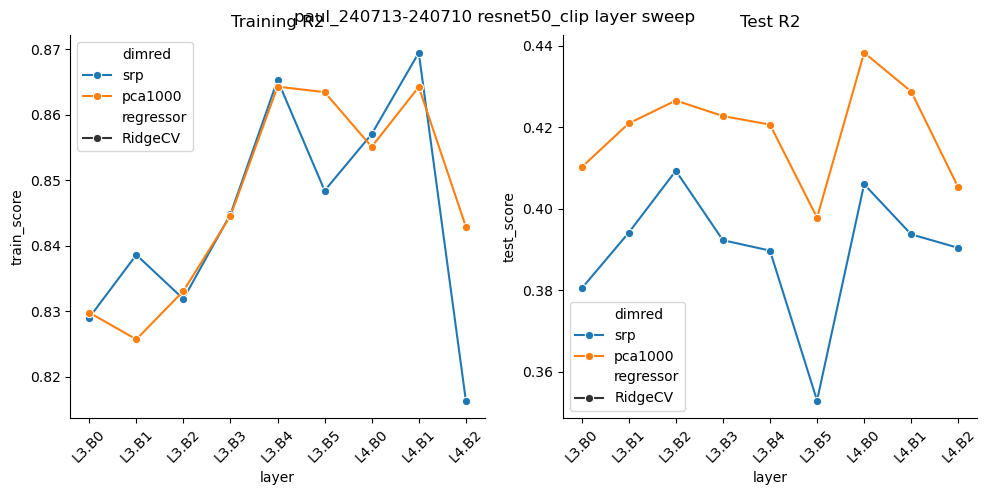

In [55]:
figh, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
             y="train_score", style="regressor", hue="dimred", ax=axs[0], marker="o")
plt.xticks(rotation=45)
xticklabels = plt.gca().get_xticklabels()
xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
plt.title("Training R2")

plt.sca(axs[1])
sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
             y="test_score", style="regressor", hue="dimred", ax=axs[1], marker="o")
plt.xticks(rotation=45)
xticklabels = plt.gca().get_xticklabels()
xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
plt.title("Test R2")

plt.tight_layout()
plt.suptitle(f"{subject_id} {modelname} layer sweep")
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis")
plt.show()

In [33]:
fit_models_lyrswp_RidgeCV

{('.layer4.Bottleneck2_srp',
  'RidgeCV'): RidgeCV(alpha_per_target=True,
         alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000.0, 10000.0, 100000.0,
                 1000000.0, 10000000.0, 100000000.0, 1000000000.0])}

In [40]:
fit_models_lyrswp_RidgeCV[('.layer4.Bottleneck2_srp','RidgeCV')].alpha_

array([ 10000.,  10000.,  10000.,  10000., 100000.,  10000., 100000.,
        10000.])

In [39]:
dir(fit_models_lyrswp_RidgeCV[('.layer4.Bottleneck2_srp','RidgeCV')])

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_decision_function',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_scorer',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_intercept',
 '_store_cv_results',
 '_validate_data',
 '_validate_params',
 'alpha_',
 

In [36]:
fit_models_lyrswp_RidgeCV[('.layer4.Bottleneck2_srp','RidgeCV')].alpha_

array([ 10000.,  10000.,  10000.,  10000., 100000.,  10000., 100000.,
        10000.])

### Plot

In [27]:
import seaborn as sns
import pandas as pd

In [ ]:
result_df_lyrswp = pd.read_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep.csv"))

In [14]:
# drop the index
result_df_lyrswp_formatted = result_df_lyrswp.reset_index()
result_df_lyrswp_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
result_df_lyrswp_formatted["layer"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[0])
result_df_lyrswp_formatted["dimred"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])
result_df_lyrswp_formatted

,layer_dimred,regressor,alpha,train_score,test_score,n_feat,layer,dimred
0,.layer1.Bottleneck0_pca1000,Ridge,10000.0,0.908870,0.179561,1000.0,.layer1.Bottleneck0,pca1000
1,.layer1.Bottleneck0_srp1000,Ridge,100000.0,0.475568,0.151367,1000.0,.layer1.Bottleneck0,srp1000
2,.layer1.Bottleneck0_srp2000,Ridge,100000.0,0.509857,0.165338,2000.0,.layer1.Bottleneck0,srp2000
3,.layer1.Bottleneck1_pca1000,Ridge,10000.0,0.936705,0.159715,1000.0,.layer1.Bottleneck1,pca1000
4,.layer1.Bottleneck1_srp1000,Ridge,100000.0,0.555608,0.113603,1000.0,.layer1.Bottleneck1,srp1000
5,.layer1.Bottleneck1_srp2000,Ridge,100000.0,0.602463,0.163641,2000.0,.layer1.Bottleneck1,srp2000
6,.layer1.Bottleneck2_pca1000,Ridge,10000.0,0.935620,0.174063,1000.0,.layer1.Bottleneck2,pca1000
7,.layer1.Bottleneck2_srp1000,Ridge,100000.0,0.548633,0.055100,1000.0,.layer1.Bottleneck2,srp1000
8,.layer1.Bottleneck2_srp2000,Ridge,100000.0,0.609109,0.148876,2000.0,.layer1.Bottleneck2,srp2000
9,.layer2.Bottleneck0_pca1000,Ridge,10000.0,0.945926,0.235484,1000.0,.layer2.Bottleneck0,pca1000


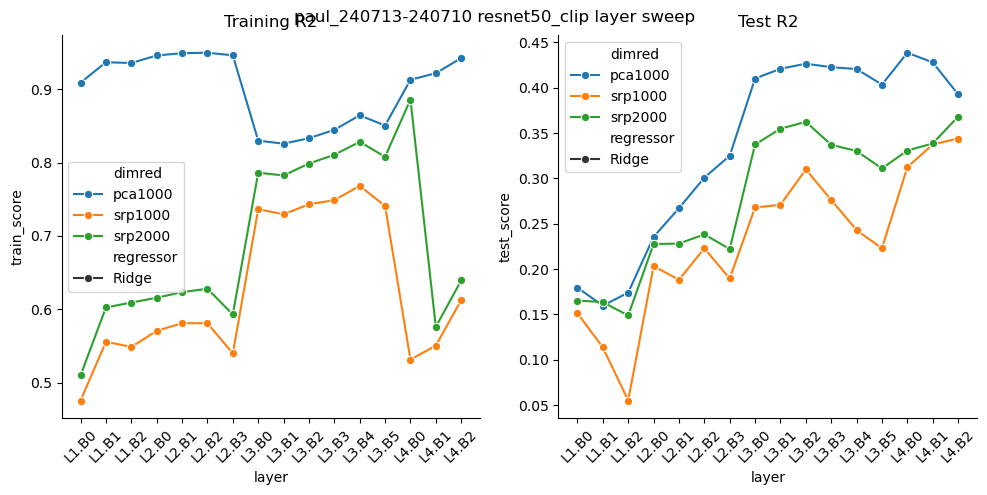

In [26]:
figh, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
             y="train_score", style="regressor", hue="dimred", ax=axs[0], marker="o")
plt.xticks(rotation=45)
xticklabels = plt.gca().get_xticklabels()
xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
plt.title("Training R2")

plt.sca(axs[1])
sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
             y="test_score", style="regressor", hue="dimred", ax=axs[1], marker="o")
plt.xticks(rotation=45)
xticklabels = plt.gca().get_xticklabels()
xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
plt.title("Test R2")

plt.tight_layout()
plt.suptitle(f"{subject_id} {modelname} layer sweep")
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis")
plt.show()

In [ ]:
fetcher = featureFetcher_module()
fetcher.record_module(model.layer4, layer_name, )
feat_dict = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()

thresh = reliability_thresh
chan_mask = reliability > thresh
resp_mat_sel = resp_mat[:, chan_mask]
print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
result_df, fit_models, Xdict, Xtfmer = perform_regression_sweeplayer(feat_dict, 
            resp_mat_sel, layer_names=[layer_name,], # 'layer2', 'layer3', 
            regressor_list=["Ridge",], dimred_list=["pca1000", "sp_cent", "sp_avg", "full"])

In [11]:
transforms_pipeline

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x147f8e61e680>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:




# %% [markdown]
batch_size = 96
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
module_names = [name for name in fetcher.module_names.values() if "Bottleneck" in name]
for name in module_names: 
    fetcher.record(name, store_device='cpu', ingraph=False, )

feat_dict = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()

# %%
fetcher = featureFetcher_module()
fetcher.record_module(model.layer1, 'layer1', ) # this is for ResNet50, specifically, modify as needed
# fetcher.record_module(model.layer1[1], 'layer1.1', ) # this is for ResNet50, specifically, modify as needed
fetcher.record_module(model.layer2, 'layer2', ) # this is for ResNet50, specifically, modify as needed
# fetcher.record_module(model.layer2[3], 'layer2.3', ) # this is for ResNet50, specifically, modify as needed
fetcher.record_module(model.layer3, 'layer3', ) # this is for ResNet50, specifically, modify as needed
# fetcher.record_module(model.layer3[5], 'layer3.5', ) # this is for ResNet50, specifically, modify as needed
fetcher.record_module(model.layer4, 'layer4', ) # this is for ResNet50, specifically, modify as needed
# fetcher.record_module(model.layer4[2], 'layer4.2', ) # this is for ResNet50, specifically, modify as needed
feat_dict = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()

# %%
result_df, fit_models, chan_mask, Xdict, Xtfmer = perform_regression_sweeplayer(feat_dict, 
            resp_mat, reliability, thresh=0.7, layer_names=['layer2', 'layer3', 'layer4',],
            ) # 'layer3', 'layer1', 
# 40.5 sec for layer4 
# 2min 20s for layer3

# %%
result_df, fit_models, chan_mask, Xdict, Xtfmer = perform_regression_sweeplayer(feat_dict, 
            resp_mat, reliability, thresh=0.7, layer_names=['layer3', 'layer4',],
            dimred_list=["pca1000", "full"]) # 'layer3', 'layer1', 
# 40.5 sec for layer4 
# 2min 20s for layer3

# %%
result_df, fit_models, chan_mask, Xdict, Xtfmer = perform_regression_sweeplayer(feat_dict, 
            resp_mat, reliability, thresh=0.7, layer_names=['layer4',],
            dimred_list=["pca1000", "full"]) # 'layer3', 'layer1', 
# 40.5 sec for layer4 
# 2min 20s for layer3

# %%
Xtfmer['layer4_pca'].transform(feat_dict['layer4'].flatten(start_dim=1))

# %%

# %%
fit_models

# %%
Xtransform = PCA_torch(Xtfmer['layer4_pca'], device=device)
readout = LinearLayer_from_sklearn(fit_models[('layer4_pca','Ridge')])

# %%


# %%
th.save(readout.state_dict(), readout_path)
pkl.dump(Xtfmer['layer4_pca'], 
open('/teamspace/studios/this_studio/model_outputs/paul_240713-240710_resnet50_robust_none_Xtransform.pkl', "wb"))

# %%
readout_path

# %%
Xtransform.mean = Xtransform.mean.float()
Xtransform.components = Xtransform.components.float()

# %% [markdown]
# ### Code export

# %%
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
import torchvision.transforms as T
import torch as th
import torch.nn as nn
import torch
import pickle as pkl
from sklearn.decomposition import PCA
from torchvision.models import resnet50

class PCA_torch(torch.nn.Module):
    def __init__(self, pca: PCA, device="cpu"):
        super(PCA_torch, self).__init__()
        self.n_features = pca.n_features_in_
        self.n_components = pca.n_components
        self.mean = torch.from_numpy(pca.mean_).float().to(device)  # (n_features,)
        self.components = torch.from_numpy(pca.components_).float().to(device)  # (n_components, n_features)

    def forward(self, X):
        if X.ndim > 2:
            X = X.flatten(start_dim=1)
        X = X - self.mean
        return torch.mm(X, self.components.T)
    
    def to(self, device):
        self.mean = self.mean.to(device)
        self.components = self.components.to(device)
        return self

readout_path = '/teamspace/studios/this_studio/model_outputs/paul_240713-240710_resnet50_robust_pca_readout.pth'
Xtransform_path = '/teamspace/studios/this_studio/model_outputs/paul_240713-240710_resnet50_robust_pca_Xtransform.pkl'
device = "cuda"
layer_name = "layer4"
model = resnet50(pretrained=False)
model.load_state_dict(th.load("/teamspace/studios/this_studio/checkpoints/imagenet_linf_8_pure.pt"))
transforms_pipeline = T.Compose([
    # T.ToTensor(),
    T.Resize((224, 224)),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
model = model.eval().to(device)
model.requires_grad_(False)
fetcher = featureFetcher_module()
fetcher.record_module(model.layer4, layer_name,  ingraph=True, store_device=device)
# # Define the readout layer and load weights
state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
pca = pkl.load(open(Xtransform_path, "rb"))
Xtransform = PCA_torch(pca, device=device)
# Define the prediction pipeline
def objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean(dim=1).mean()


def objective_unit(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)[:, 1].mean()


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None

check_gradient(objective)

# %%
from horama import maco, plot_maco
image1, alpha1 = maco(objective, device='cuda')
plot_maco(image1, alpha1)

# %%


# %%
Xtfmer(feat_dict['layer4'])

# %%

class NeuralObjective:
    """Class to rebuild the objective function for optimization."""
    def __init__(self, model, readout_path, meta_path, feature_transform="sp_avg", layer_name="last_block", device="cuda"):
        
        model = resnet50(pretrained=False)
        model.load_state_dict(th.load("/teamspace/studios/this_studio/checkpoints/imagenet_linf_8_pure.pt"))
        transforms_pipeline = T.Compose([
            # T.ToTensor(),
            T.Resize((224, 224)),
            # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        self.model = model.eval().to(device)
        self.model.requires_grad_(False)
        # Get model specific transforms (normalization, resize)
        self.transforms = transforms_pipeline
        self.fetcher = featureFetcher_module()
        self.fetcher.record_module(model.layer4, layer_name,  ingraph=True, store_device=device) # this is for ResNet50, specifically, modify as needed
        # self.fetcher.record_module(self.model.blocks[-1], layer_name, ingraph=True, store_device=device)
        # Load readout
        state_dict = th.load(readout_path)
        meta = th.load(meta_path)
        self.chan_mask = meta["channel_mask"]
        self.reliability = meta["reliability"]
        self.ncsnr = meta["ncsnr"]
        self.D2 = meta["D2"]
        # Define the readout layer and load weights
        self.readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).to(device)
        self.readout.load_state_dict(state_dict)
        self.device = device
        if feature_transform == "sp_avg":
            self.Xfeat_transform = lambda tsr: tsr.mean(dim=(2,3))  # Modify as needed
        elif feature_transform == "sp_rf":
            self.Xfeat_transform = lambda tsr: tsr[:, :, 4:6, 4:6].mean(dim=(2,3))  # Modify as needed
        elif feature_transform == "cls":
            self.Xfeat_transform = lambda tsr: tsr[:, 0, :]
        elif feature_transform == "none":
            self.Xfeat_transform = lambda tsr: tsr.flatten(start_dim=1)  # Modify as needed
        # else if it's callable, use it as is
        elif callable(feature_transform):
            self.Xfeat_transform = feature_transform
        else:
            raise NotImplementedError(f"Invalid feature transform: {feature_transform}")

    def objective(self, images):
        """Compute the objective function over images."""
        # Forward pass through the feature extractor
        self.model(self.transforms(images))
        feat_tsr = self.fetcher["last_block"]  # Access the layer feature
        feat_vec = self.Xfeat_transform(feat_tsr)
        return self.readout(feat_vec).mean(dim=-1).mean()

    def unit_objective(self, images, unit_id):
        """Compute the objective function for a specific unit."""
        # Forward pass through the feature extractor
        self.model(self.transforms(images))
        feat_tsr = self.fetcher["last_block"]  # Access the layer feature
        feat_vec = self.Xfeat_transform(feat_tsr)
        return self.readout(feat_vec)[:, unit_id].mean()

    def cleanup(self):
        self.fetcher.cleanup()
        del self.fetcher


def optimize_maco(objective_fn, total_steps=100, learning_rate=1.0, image_size=1280,
                  model_input_size=224, noise=0.25, values_range=(-2.5, 2.5),
                  crops_per_iteration=6, box_size=(0.20, 0.25), device='cuda'):
    """Optimize the objective function using MACO."""
    image, alpha = maco(
        objective_fn, total_steps=total_steps, learning_rate=learning_rate, image_size=image_size,
        model_input_size=model_input_size, noise=noise, values_range=values_range,
        crops_per_iteration=crops_per_iteration, box_size=box_size, device=device
    )
    return image, alpha


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None


def visualize_results(img_col, D2, ):
    """Visualize the optimized images."""
    figh, axs = plt.subplots(3, 5, figsize=(25, 15))
    for i, ax in enumerate(axs.flat):
        plt.sca(ax)
        if i >= len(img_col):
            ax.axis("off")
            continue
        tup = img_col[i]
        plot_maco(tup[0], tup[1])
        plt.title(f"Unit {i} R2={D2[i]:.2f}")
    plt.suptitle(f"{subject_id} {modelname} {RD_method} MACO unit compilation")
    saveallforms(figdir, f"{subject_id}_{modelname}_{RD_method}_MACO_unit_cmp")

#%% Main Execution

def main(subject_id = 'paul_20240713-20240710',
         modelname = "resnet50_robust",# "flexivit_base.1000ep_in21k",
         RD_method = "none",
         batch_size = 48,
        figdir = "/teamspace/studios/this_studio/model_outputs",
        device = "cuda",):
    # Parameters
    data_path = "/teamspace/studios/monkey-data-studio/nsd_shared1000_6monkeys_2024.h5"
    stimroot = "/teamspace/studios/this_studio/shared1000"
    layer_name = "last_block"
    # RD_method = "sp_rf"
    
    readout_path = join(figdir, f"{subject_id}_{modelname}_{RD_method}_readout.pth")
    meta_path = join(figdir, f"{subject_id}_{modelname}_{RD_method}_meta.pth")
    
    maco_hyperparams = dict(total_steps=500, learning_rate=1.0, image_size=1280,
         model_input_size=224, noise=0.10, values_range=(-2.5, 2.5),
         crops_per_iteration=6, box_size=(0.20, 0.25),)
        
    # Load data
    data_dict = load_neural_data(data_path, subject_id, stimroot)
    image_fps = data_dict['image_fps']
    resp_mat = data_dict['resp_mat']
    reliability = data_dict['reliability']
    ncsnr = data_dict['ncsnr']

    # Prepare model and transforms
    if modelname == "resnet50_robust":
        model = resnet50(pretrained=False)
        model.load_state_dict(th.load("/teamspace/studios/this_studio/checkpoints/imagenet_linf_8_pure.pt"))
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50":
        model = resnet50(pretrained=True)
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50_clip":
        raise NotImplementedError("CLIP model not supported yet.")
        pass
    # model = timm.create_model(modelname, pretrained=True).to(device).eval()
    # data_config = timm.data.resolve_model_data_config(model)
    # transforms_pipeline = timm.data.create_transform(**data_config, is_training=False)
    # Prepare dataset
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
    # Extract features
    feat_dict = extract_features(model, dataset, layer_name=layer_name, batch_size=batch_size, device=device)
    # Perform regression
    result_df, fit_models, chan_mask, Xdict = perform_regression(feat_dict, resp_mat, reliability, thresh=0.5)
    result_df.to_csv(join(figdir, f"sweep_regressors_highreliab_{modelname}.csv"))
    # Save regression results
    # Save readout and meta
    readout = LinearLayer_from_sklearn(fit_models[(RD_method, 'Ridge')])
    with th.no_grad():
        pred_resp = readout(th.tensor(Xdict[RD_method]).float())
    resp_mat_sel = resp_mat[:, chan_mask]
    D2 = 1 - ((resp_mat_sel - pred_resp.numpy())**2).mean(axis=0) / ((resp_mat_sel - resp_mat_sel.mean(axis=0))**2).mean(axis=0)
    print(D2)
    th.save(readout.state_dict(), readout_path)
    th.save({
        "channel_mask": chan_mask,
        "reliability": reliability[chan_mask],
        "ncsnr": ncsnr[chan_mask],
        "D2": D2
    }, meta_path)

    # Rebuild the objective function
    neural_obj = NeuralObjective(modelname, readout_path, meta_path, layer_name=layer_name, device=device,
                                 feature_transform=RD_method)
    # Check gradient
    check_gradient(neural_obj.objective)
    # Optimization part 1: MACO
    image1, alpha1 = maco(neural_obj.objective, **maco_hyperparams, device='cuda')
    plot_maco(image1, alpha1)
    saveallforms(figdir, f"{subject_id}_{modelname}_{RD_method}_MACO_population_mean")
    plt.show()

    # Optimizing individual units
    img_col = []
    for unit_id in range(len(D2)):
        print(f"Optimizing unit {unit_id}")
        print(f"D^2: {neural_obj.D2[unit_id]}")
        unit_objective = lambda images: neural_obj.unit_objective(images, unit_id)
        image_unit, alpha_unit = maco(unit_objective, **maco_hyperparams, device='cuda')
        img_col.append((image_unit, alpha_unit))
        plot_maco(image_unit, alpha_unit)

    # Visualization
    visualize_results(img_col, neural_obj.D2, subject_id, modelname, RD_method, figdir=figdir)

    # Cleanup
    neural_obj.cleanup()

if __name__ == "__main__":
    main(subject_id='paul_240713-240710')

# %% [markdown]
# ### Scratch

# %%
result_df, fit_models, chan_mask, Xdict = perform_regression_sweeplayer(feat_dict, 
            resp_mat, reliability, thresh=0.7, layer_names=[
                                                            '.layer3.Bottleneck3',
                                                            '.layer3.Bottleneck4',
                                                            '.layer3.Bottleneck5',
                                                            '.layer4.Bottleneck0',
                                                            '.layer4.Bottleneck1',
                                                            '.layer4.Bottleneck2']) 

# %% [markdown]
# ### Load the CLIP model

# %%
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# %%
clip.available_models()

# %%
model, preprocess = clip.load('RN50x16', device=device)

# %%
model, preprocess = clip.load('RN50', device=device)

# %%
preprocess

# %%
get_module_names(model.visual, input_size=(3, 224, 224), device=device)

# %%
get_module_names(model.visual, input_size=(3, 384, 384), device=device)

# %%



